### References

## Fashion-MNIST Classification

> Can we develop a model that has good performance on the Fashion-MNIST dataset?

### Context
Fashion-MNIST is a dataset from Zalando research, comprising of <code>28 x 28</code> grayscale images of a total fo <code>70000</code> fashion products from 10 categories. The intent of this dataset is to serve as a replacement for the MNIST dataset for testing and benchmarking machine learning and deep learning models (Xiao, Rasul and Vollgraf, 2017).

The dataset is based on images from Zalando's assortment. Each original image of <code>762 x 1000</code> in JPEG format was converted to PNG, resized, and then converted to grayscale.

### Objectives
<ol>
	<li>To explore and understand the dataset</li>
	<li>Understand the effects of different data augmentation techniques on the performance of the model</li>
	<li>Develop and experiment with models to rival state-of-the-art (SOTA) benchmark scores</li>
</ol>

## Importing libraries
We import the necessary libraries for the notebook to run below.

In [73]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set('notebook')
from PIL import Image

## Helper Functions
Below we define some utility and helper functions that will ease and help us with our analysis.

In [33]:
def loc_data(data, loc):
	datacopy = copy.deepcopy(data)
	arr = np.array(datacopy.loc[loc].drop('label'))
	label = datacopy.loc[loc]['label']
	root = int(len(arr) ** 0.5)
	arr.resize((root, root))
	return label, arr

## Dataset
Let's take a look at the dataset. This dataset was retrieved from the original Fashion MNIST dataset found at <a href="https://arxiv.org/pdf/1708.07747v2.pdf">Paper Link</a>. 

<table>
	<tr>
		<th>
			Column Name
		</th>
		<th>
			Description
		</th>
	</tr>
	<tr>
		<td>
			label
		</td>
		<td>
			The true class of the image, represented as an integer ranging from 0 to 9<strong>*</strong>
		</td>
	</tr>
	<tr>
		<td>
			pixel 1<br/>...<br/>pixel 784
		</td>
		<td>
			Pixels representing the image, each pixel ranging from 0 to 255
		</td>
	</tr>
</table>

<strong>\*</strong>Each number represents a certain dress item
```
0 -> T-shirt/top
1 -> Trouser
2 -> Pullover
3 -> Dress
4 -> Coat
5 -> Sandal
6 -> Shirt
7 -> Sneaker
8 -> Bag
9 -> Ankle boot
```

Let's take a look at the training dataset

In [13]:
train = pd.read_csv('data/fashion-mnist_train.csv')
train.shape

(60000, 785)

We observe that there are a total of <code>60000</code> rows and <code>785</code> columns, which is exactly what the original paper mentioned.

### Testing for missing values and invalid data
Let's try to identify if there are any missing values

In [19]:
train.isnull().sum().sum()

0

It appears <strong>no missing values are found</strong>. We will then check for any potential typos.
<ol>
	<li>Firstly, the label should only consist of values from 0 - 9</li>
	<li>Secondly, the pixel values should only fall in between and inclusive of 0 - 255</li>
</ol>

In [27]:
print('Minimum and Maximum values of labels:', train['label'].min(), train['label'].max())
print("Number of values falling outside the range (0 - 255):",
	train.applymap(
		lambda x: x < 0 or x > 255 # True if out of range
	).sum().sum()
)

Minimum and Maximum values of labels: 0 9
Number of values falling outside the range (0 - 255): 0


We observe that the dataset seems to be properly cleaned, thus can proceed knowing that <strong>no sign of invalid or missing data have been found.</strong>

## Exploratory Data Analysis
Before we begin the EDA, we first need to remove a chunk of the training data to be used as validation dataset in order to avoid data leakage due to the decisions we make during EDA.

### Validation Dataset
Let's make our validation dataset. I decided that I will <strong>not be using cross validation during the modelling process</strong> due to:
<ul>
	<li>Time taken to train models, especially if utilising expensive layers, activation functions or architecture</li>
	<li>Additionally due to the sheer size of the dataset, not only does this add to increased training time but also means there is enough data such that cross validation is not necessary</li>
</ul>

We'll use a validation size of <code>10000</code> to mimic the size of the test dataset

In [45]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('label', axis=1), train['label'], test_size = 10000 / len(train), stratify=train['label'])
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (50000, 784)
X_val shape: (10000, 784)
y_train shape: (50000,)
y_val shape: (10000,)


Now we can begin our EDA!

### Class Imbalance
We'll first identify the situation with class imbalance

<AxesSubplot: xlabel='label', ylabel='Count'>

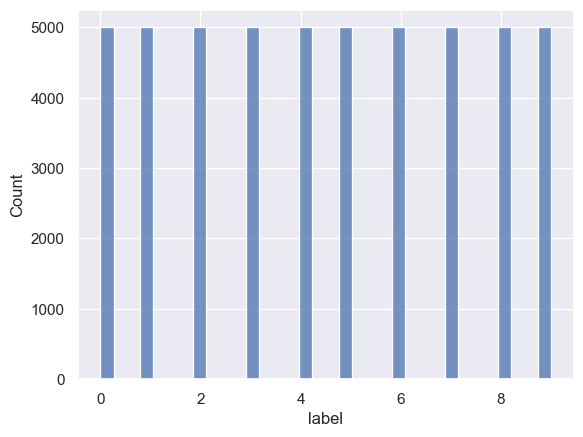

In [74]:
sns.histplot(y_train)